# Предложение 4

Наличные платежи становятся менее популярными. Необходимо обеспечить бесперебойную работу процессора для карт.

In [1]:
import os
from dotenv import load_dotenv
import json
import clickhouse_connect
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [2]:
# Read configuration
with open('./dags/conf/config.json', 'r') as f:
    CONFIG = json.load(f)

# Make a shortcut for database name
db = CONFIG['clickhouse']['dbs']['golden_db']
# TODO
CONFIG['clickhouse']['host'] = 'localhost'

# Get credentials
load_dotenv(dotenv_path='./dags/conf/.env', override=True)

try:
    # Get Clickhouse client
    ch_client = clickhouse_connect.get_client(
        host=CONFIG['clickhouse']['host'],
        port=CONFIG['clickhouse']['port'],
        username=os.getenv('CLICKHOUSE_USER'),
        password=os.getenv('CLICKHOUSE_PASS')
    )
except Exception as e:
    print(f"Error connecting to Clickhouse: {e}")


In [3]:
sql = f"""
    SELECT DATE_TRUNC('month', ft.pickup_datetime) AS year_month, SUM(pt.is_cash) as cash, SUM(pt.is_digital) as digital,
            SUM(pt.is_cash) / COUNT(pt.is_cash) AS cash_ratio,
            SUM(pt.is_digital) / COUNT(pt.is_digital) AS digital_ratio
        FROM {db}.fact_trip ft
        INNER JOIN {db}.dim_payment_type pt
            ON ft.payment_type = pt.payment_type_id
    GROUP BY year_month
    ORDER BY year_month
"""
# Get monthly distribution of payment types
try:
    payment_by_month = ch_client.query_df(sql)

except Exception as e:
    print(f'Error reading payment types by months: {e}')

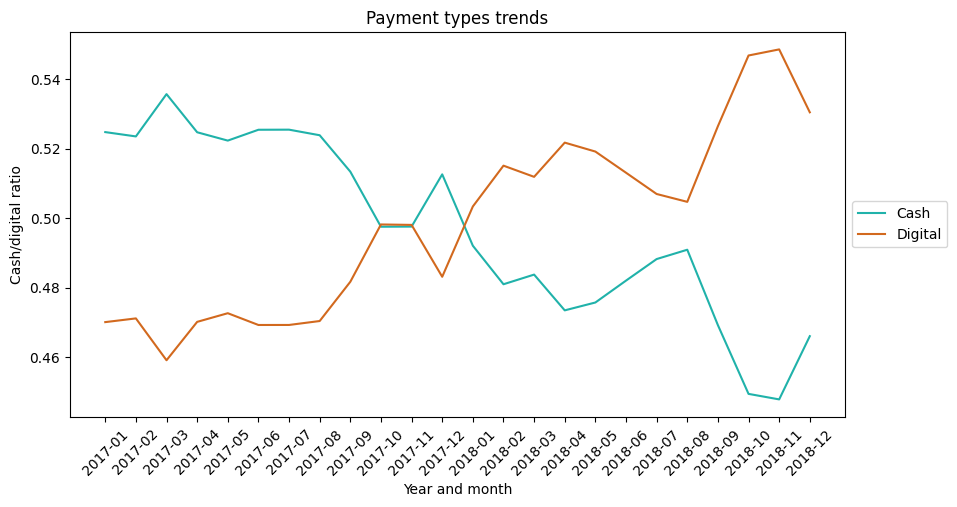

In [4]:
# Payment types distribution by month
plt.figure(figsize=(10,5))
plt.plot(payment_by_month['year_month'].astype(str).str[:-3], payment_by_month['cash_ratio'], color='lightseagreen', label='Cash')
plt.plot(payment_by_month['year_month'].astype(str).str[:-3], payment_by_month['digital_ratio'], color='chocolate', label='Digital')

plt.xlabel('Year and month')
plt.xticks(rotation=45)
plt.ylabel('Cash/digital ratio')
plt.title('Payment types trends')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [5]:
# Get future trend with simple moving aggregate for smoothing
# Set months count to forecast
forecast_period = 6
# Set rolling window, months
window = 3

# Calculate SMA
payment_by_month['digital_ratio_sma'] = payment_by_month['digital_ratio'].rolling(window=window).mean()

print(payment_by_month.head(20))



   year_month    cash  digital  cash_ratio  digital_ratio  digital_ratio_sma
0  2017-01-01  464356   415971    0.524727       0.470052                NaN
1  2017-02-01  449233   404298    0.523483       0.471121                NaN
2  2017-03-01  513798   440343    0.535657       0.459077           0.466750
3  2017-04-01  473415   424187    0.524682       0.470123           0.466774
4  2017-05-01  465308   421059    0.522282       0.472615           0.467271
5  2017-06-01  430074   384091    0.525403       0.469227           0.470655
6  2017-07-01  400673   357821    0.525429       0.469234           0.470359
7  2017-08-01  376654   338215    0.523824       0.470366           0.469609
8  2017-09-01  375134   351978    0.513346       0.481658           0.473753
9  2017-10-01  382807   383309    0.497499       0.498151           0.483392
10 2017-11-01  355690   356037    0.497540       0.498026           0.492612
11 2017-12-01  383442   361395    0.512572       0.483100           0.493092

In [6]:
# Prepare data for linear regression
X = np.arange(len(payment_by_month)).reshape(-1, 1)
y = payment_by_month['digital_ratio_sma'].values

# Model linear regression
model = LinearRegression()
# Learn data avoiding first NaNs
model.fit(X[window-1:], y[window-1:])

future_X = np.arange(len(payment_by_month) + forecast_period).reshape(-1, 1)
forecast = model.predict(future_X)
print(forecast)


[0.45279859 0.45640643 0.46001427 0.46362211 0.46722994 0.47083778
 0.47444562 0.47805346 0.4816613  0.48526914 0.48887698 0.49248482
 0.49609266 0.4997005  0.50330834 0.50691618 0.51052402 0.51413186
 0.5177397  0.52134754 0.52495538 0.52856322 0.53217106 0.5357789
 0.53938674 0.54299458 0.54660242 0.55021026 0.5538181  0.55742594]


In [7]:
# Generate future dates
future_months = pd.date_range(payment_by_month['year_month'].iloc[-1] + pd.offsets.MonthBegin(), periods=forecast_period, freq='MS')
print(future_months)


DatetimeIndex(['2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01'],
              dtype='datetime64[ns]', freq='MS')


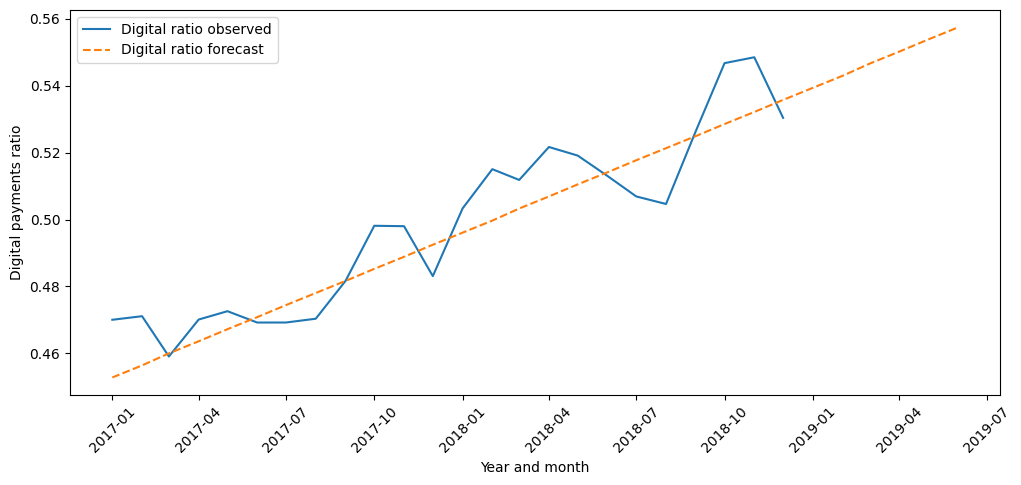

In [8]:
# Plot digital trend
plt.figure(figsize=(12,5))
plt.plot(payment_by_month['year_month'], payment_by_month['digital_ratio'], label='Digital ratio observed')
plt.plot(
    pd.concat([payment_by_month['year_month'], pd.Series(future_months)], ignore_index=True),
    forecast,
    '--',
    label='Digital ratio forecast'
)
plt.xlabel('Year and month')
plt.ylabel('Digital payments ratio')
plt.xticks(rotation=45)
plt.legend()
plt.show()